# 03 Time series

In this notebook we use traditional time series approaches.

## Reading data

We read the datasets from the csv files.

In [119]:
# Basic packages
import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import time

# Time series packages

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

sales = pd.read_csv('data/sales_train.csv')
items = pd.read_csv('data/items.csv')
test = pd.read_csv('data/test.csv')

sales.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.0,899.0,899.0,1709.05,1099.0
item_cnt_day,1.0,1.0,-1.0,1.0,1.0


We convert the date into a datetime object.

In [120]:
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [121]:
# We keep only shops and items present in the test dataset
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

sales = sales[(sales['shop_id'].isin(test_shop_ids)) & sales['item_id'].isin(test_item_ids)]

sales.head().T

,0,10,11,12,13
date,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-05 00:00:00,2013-01-07 00:00:00,2013-01-08 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2574,2574,2574,2574
item_price,999.0,399.0,399.0,399.0,399.0
item_cnt_day,1.0,2.0,1.0,1.0,2.0


In [122]:
# Aggregate data per month
monthly_sales = sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
monthly_sales = monthly_sales.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean','count']})

# And rename the columns
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0


In [123]:
n_months = 34
date_block_nums = range(n_months)

shop_ids = monthly_sales['shop_id'].unique()

full_sales = []
for date_block_num in date_block_nums:
    for shop_id in shop_ids:
        shop_monthly_sales = monthly_sales[monthly_sales['shop_id'] == shop_id]

        item_ids = shop_monthly_sales['item_id'].unique()
        for item_id in item_ids:
            full_sales.append([date_block_num, shop_id, item_id])

full_sales = pd.DataFrame(full_sales, columns=['date_block_num', 'shop_id', 'item_id'])

full_sales.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,2,2,2,2,2
item_id,33,482,491,839,1007


In [124]:
monthly_sales = pd.merge(full_sales, monthly_sales, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

monthly_sales = pd.merge(monthly_sales, items[['item_id', 'item_category_id']], how='left')

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0


In [125]:
monthly_sales['year'] = 2013 + monthly_sales['date_block_num'] // 12
monthly_sales['month'] = monthly_sales['date_block_num'] % 12

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0
year,2013.0,2013.0,2013.0,2013.0,2013.0


In [126]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = monthly_sales.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = monthly_sales.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

Text(0.5, 1.0, 'Montly sum')

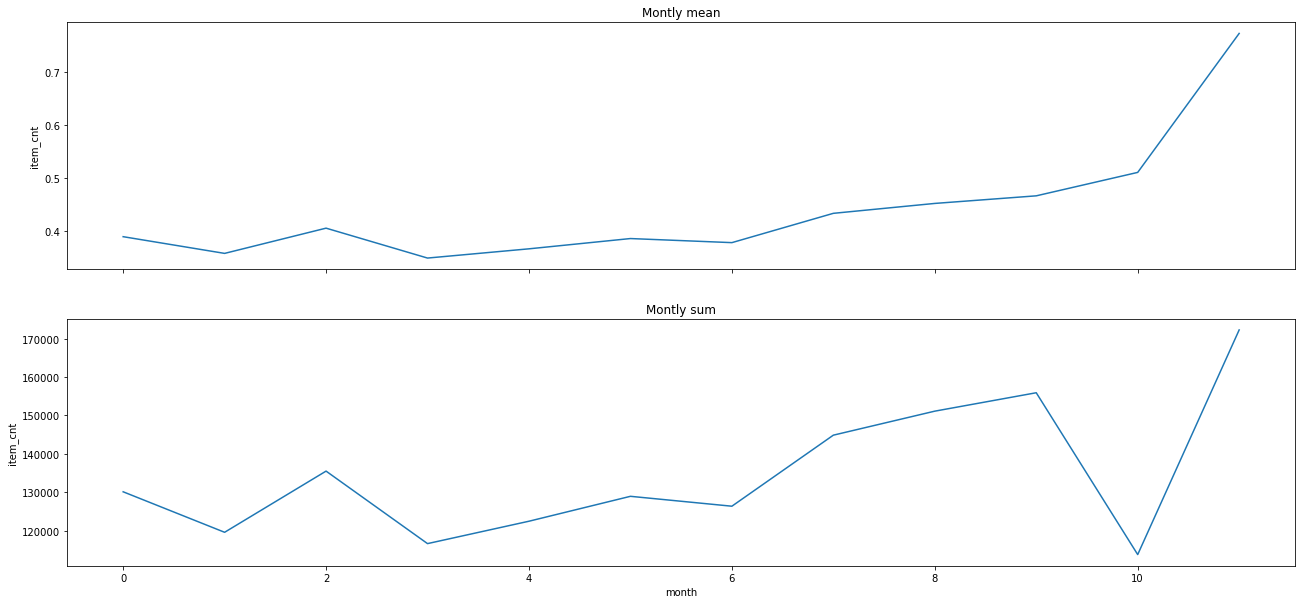

In [127]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axs[0]).set_title('Montly mean')
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axs[1]).set_title('Montly sum')

Text(0.5, 1.0, 'Montly sum')

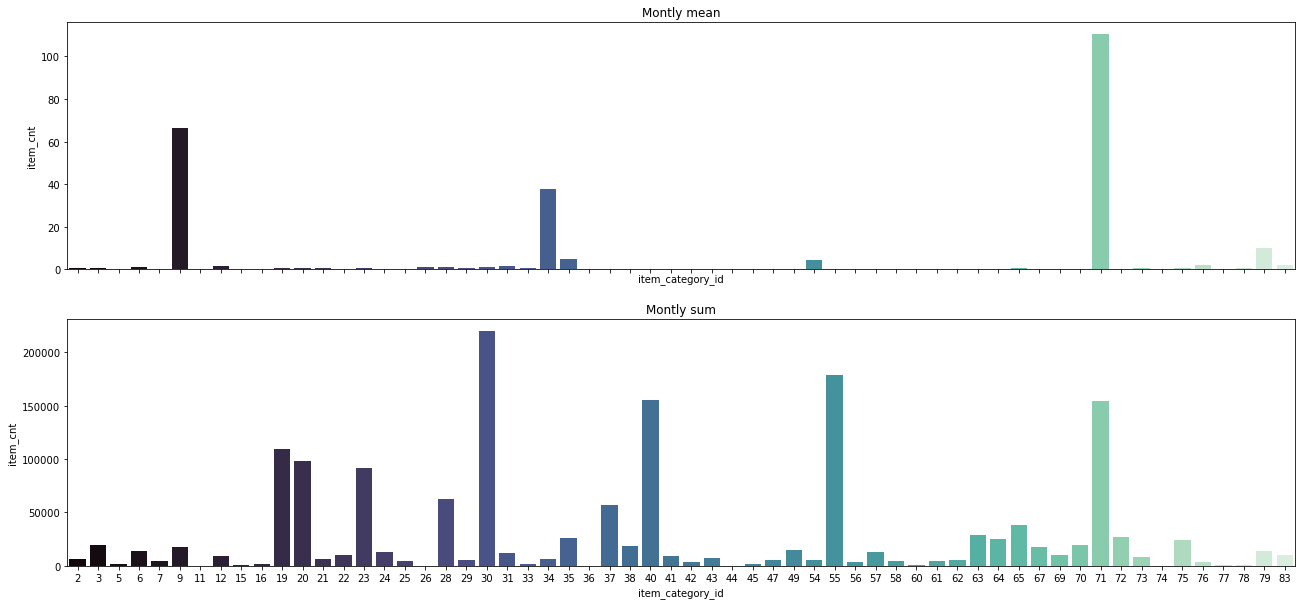

In [128]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axs[0], palette='mako').set_title('Montly mean')
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axs[1], palette='mako').set_title('Montly sum')

Text(0.5, 1.0, 'Montly sum')

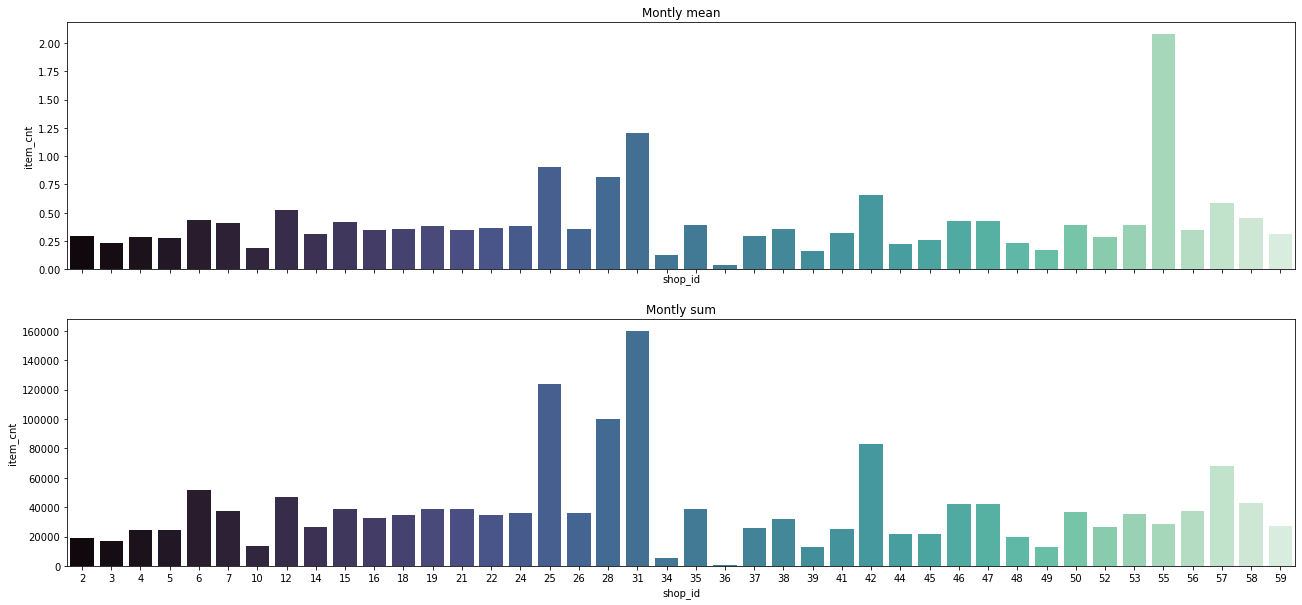

In [129]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axs[0], palette='mako').set_title('Montly mean')
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axs[1], palette='mako').set_title('Montly sum')

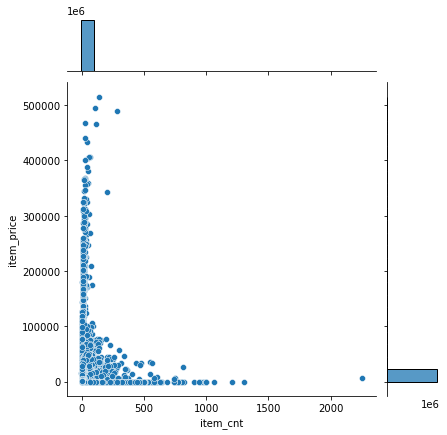

In [130]:
sns.jointplot(x='item_cnt', y='item_price', data=monthly_sales)

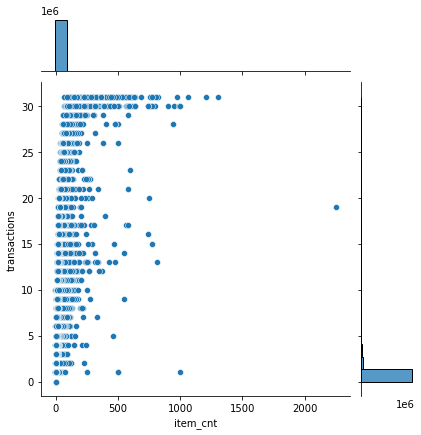

In [131]:
sns.jointplot(x='item_cnt', y='transactions', data=monthly_sales)

In [132]:
monthly_sales['item_cnt_month'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

monthly_sales['item_price_unit'] = monthly_sales['item_price'] // monthly_sales['item_cnt']
monthly_sales['item_price_unit'] = monthly_sales['item_price_unit'].fillna(0).replace([np.inf, -np.inf], 0)

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0
year,2013.0,2013.0,2013.0,2013.0,2013.0


In [133]:
gp_item_price = monthly_sales.groupby(['item_id'], as_index=False).agg({'item_price': [np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

gp_item_price.head().T

,0,1,2,3,4
item_id,30.0,31.000000,32.0,33.0,38.0
hist_min_item_price,0.0,0.000000,0.0,0.0,0.0
hist_max_item_price,9975.0,10938.333333,8027.0,2994.0,4798.0


In [134]:
monthly_sales = pd.merge(monthly_sales, gp_item_price, on='item_id', how='left')

# Price differences from historical min/max
monthly_sales['price_increase'] = monthly_sales['item_price'] - monthly_sales['hist_min_item_price']
monthly_sales['price_decrease'] = monthly_sales['hist_max_item_price'] - monthly_sales['item_price']

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0
year,2013.0,2013.0,2013.0,2013.0,2013.0


In [135]:
# Rolling window based features
window = 3

gp_monthly_sales = monthly_sales.sort_values('date_block_num').groupby(['shop_id', 'item_id'])

# Actual value of last 3 months
for i in range(1, window + 1):
    monthly_sales['item_cnt_shifted_' + str(i)] = gp_monthly_sales['item_cnt'].shift(i).fillna(0)

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0
year,2013.0,2013.0,2013.0,2013.0,2013.0


In [136]:
shifted = monthly_sales[[col for col in monthly_sales if col.startswith('item_cnt_shifted')]]

# Min, max, mean and std of last 3 months
monthly_sales['item_cnt_min'] = shifted.min(axis=1)
monthly_sales['item_cnt_max'] = shifted.max(axis=1)
monthly_sales['item_cnt_mean'] = shifted.mean(axis=1)
monthly_sales['item_cnt_std'] = shifted.std(axis=1)

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,33.0,482.0,491.0,839.0,1007.0
item_price,499.0,3300.0,600.0,3300.0,1347.0
mean_item_price,499.0,3300.0,600.0,3300.0,449.0
item_cnt,1.0,1.0,1.0,1.0,3.0
mean_item_cnt,1.0,1.0,1.0,1.0,1.0
transactions,1.0,1.0,1.0,1.0,3.0
item_category_id,37.0,73.0,73.0,73.0,67.0
year,2013.0,2013.0,2013.0,2013.0,2013.0


In [137]:
# Item trend with respect to last 3 months
monthly_sales['item_trend'] = (monthly_sales['item_cnt'] - shifted.sum(axis=1)) / (window + 1)

monthly_sales.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00
item_price,499.00,3300.00,600.00,3300.00,1347.00
mean_item_price,499.00,3300.00,600.00,3300.00,449.00
item_cnt,1.00,1.00,1.00,1.00,3.00
mean_item_cnt,1.00,1.00,1.00,1.00,1.00
transactions,1.00,1.00,1.00,1.00,3.00
item_category_id,37.00,73.00,73.00,73.00,67.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [138]:
monthly_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,3787736.0,16.500000,9.810710,0.000000,8.0,16.5,25.000000,33.000000
shop_id,3787736.0,31.399268,17.267553,2.000000,16.0,31.0,47.000000,59.000000
item_id,3787736.0,10884.147041,6154.421670,30.000000,5241.0,10889.0,16028.000000,22167.000000
item_price,3787736.0,333.177295,2895.031579,0.000000,0.0,0.0,0.000000,515573.589744
mean_item_price,3787736.0,144.423994,706.584624,0.000000,0.0,0.0,0.000000,42990.000000
item_cnt,3787736.0,0.427108,4.600424,-4.000000,0.0,0.0,0.000000,2253.000000
mean_item_cnt,3787736.0,0.172994,0.808252,-2.000000,0.0,0.0,0.000000,1000.000000
transactions,3787736.0,0.323264,1.187273,0.000000,0.0,0.0,0.000000,31.000000
item_category_id,3787736.0,43.847564,16.790944,2.000000,30.0,40.0,55.000000,83.000000
year,3787736.0,2013.941176,0.802246,2013.000000,2013.0,2014.0,2015.000000,2015.000000


In [150]:
# Train set: Months 3 to 27 (drop 0 to 2 as we use 3-month window)
train_set = monthly_sales[(monthly_sales['date_block_num'] >= 3) & (monthly_sales['date_block_num'] < 28)].dropna().copy()
# Validation set: Months 28 to 32
validation_set = monthly_sales[(monthly_sales['date_block_num'] >= 28) & (monthly_sales['date_block_num'] < 33)].dropna().copy()
# Test set: Month 33 (last with available data)
test_set = monthly_sales[monthly_sales['date_block_num'] == 33].copy()

train_set_perc = 100 * train_set.shape[0] / monthly_sales.shape[0]
validation_set_perc = 100 * validation_set.shape[0] / monthly_sales.shape[0]
test_set_perc = 100 * test_set.shape[0] / monthly_sales.shape[0]

train_set_perc, validation_set_perc, test_set_perc

(73.52941176470588, 14.705882352941176, 2.9411764705882355)

## Linear regression

In this case, we are going to perform linear regression on the monthly item counts, for every shop and item. In order to validate our predictions, we split the train dataset into the first months and the last one.

In [55]:
# Number of months in the training dataset
n_months = 33

# Split dataset into training and validation
last_month = train_data[train_data['date_block_num'] == n_months]
first_months = train_data[train_data['date_block_num'] < n_months]

first_months.shape, last_month.shape

((2882335, 6), (53514, 6))

Now we aggregate the data by adding up all the daily item counts over each month.

In [141]:
# Aggregate datasets per month
first_agg_month = first_months.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'item_cnt_month'})
last_agg_month = last_month.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'item_cnt_month'})

first_agg_month.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


We now create a new dataframe containing, for each shop and item, the coefficients of the linear regression.

In [182]:
# Create constant series with all date_block_nums
date_block_nums = pd.Series(range(n_months), name='date_block_num')

# Empty dataframe to store the results of the linear regression
first_agg_all_time = pd.DataFrame()

# Iterate over shops
shop_ids = first_agg_month['shop_id'].unique()
for shop_id in shop_ids:
    first_agg_month_shop = first_agg_month[first_agg_month['shop_id'] == shop_id]

    print(shop_id, end=' ')

    # Iterate over the items of the given shop
    item_ids = first_agg_month_shop['item_id'].unique()
    for item_id in item_ids:
        first_agg_month_shop_item = first_agg_month_shop[first_agg_month_shop['item_id'] == item_id]

        # Merge the dataframe so it has zeros for months with no item counts
        x = pd.merge(date_block_nums, first_agg_month_shop_item, how='left').fillna(0)
        # Fit the linear regression coefficients
        b, m = polyfit(x['date_block_num'], x['item_cnt_month'], deg=1)

        # Append a new row to the aggregated dataframe
        row = pd.DataFrame([[shop_id, item_id, b, m]], columns=['shop_id', 'item_id', 'lr_b', 'lr_m'])
        first_agg_all_time = first_agg_all_time.append(row)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

We reset the indices and compute our predictions.

In [217]:
first_agg_all_time = first_agg_all_time.reset_index(drop=True)

first_agg_all_time['pred_33'] = first_agg_all_time['lr_b'] + first_agg_all_time['lr_m'] * 33
first_agg_all_time['pred_33'] = first_agg_all_time['pred_33'].clip(lower=0)

first_agg_all_time.head()

,shop_id,item_id,lr_b,lr_m,pred_33
0,0,30,3.426025,-0.155414,0.0
1,0,31,1.215686,-0.055147,0.0
2,0,32,1.800357,-0.082219,0.0
3,0,33,0.679144,-0.031083,0.0
4,0,35,1.663102,-0.075535,0.0


And we finally put together in the same dataframe our predictions with the ground truth.

In [218]:
predictions = pd.merge(first_agg_all_time[['shop_id', 'item_id', 'pred_33']], last_agg_month[['shop_id', 'item_id','item_cnt_month']], on=['shop_id', 'item_id'], how='left').rename(columns={'item_cnt_month': 'true_item_cnt'}).fillna(0)

# Compute the squared error
predictions['se'] = (predictions['pred_33'] - predictions['true_item_cnt'])**2

predictions.head()

,shop_id,item_id,pred_33,true_item_cnt,se
0,0,30,0.0,0.0,0.0
1,0,31,0.0,0.0,0.0
2,0,32,0.0,0.0,0.0
3,0,33,0.0,0.0,0.0
4,0,35,0.0,0.0,0.0


The rooted mean square error is the metric we are considering for the error. Its value is rather high, this is due to the naive approach for the predictions.

In [219]:
# Compute the rooted mean squared error
rmse = np.sqrt(predictions['se'].mean())

rmse

3.447228314471813

## Submission

We are now ready to submit our predictions. To avoid repeating the training with the whole dataset, we will abuse the data and use the linear regression coefficients for the first 33 months instead of the first 34.

In [220]:
first_agg_all_time['pred_34'] = first_agg_all_time['lr_b'] + first_agg_all_time['lr_m'] * 34
first_agg_all_time['pred_34'] = first_agg_all_time['pred_34'].clip(lower=0)

first_agg_all_time.head()

,shop_id,item_id,lr_b,lr_m,pred_33,pred_34
0,0,30,3.426025,-0.155414,0.0,0.0
1,0,31,1.215686,-0.055147,0.0,0.0
2,0,32,1.800357,-0.082219,0.0,0.0
3,0,33,0.679144,-0.031083,0.0,0.0
4,0,35,1.663102,-0.075535,0.0,0.0


We finally generate the csv file ready for submission.

In [221]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test_data, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)
    print("Submission successfully saved!")

In [222]:
generate_submission_file(first_agg_all_time, 'pred_34')

Submission successfully saved!
